### Importing libraries

In [0]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import spacy
import scipy.io
import gc
from sklearn.preprocessing import LabelEncoder
import pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras import Input
from keras.layers.recurrent import LSTM
from keras.layers import concatenate
from keras.layers.merge import Concatenate
from keras.models import model_from_json, Model
from keras.utils import plot_model
from collections import defaultdict
import operator
from keras.utils import np_utils, generic_utils
from progressbar import Bar, ETA, Percentage, ProgressBar
from itertools import zip_longest
from keras.models import load_model

In [53]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/DL_Group/Project/DATA/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Reading the text files that contains extracted questions and annotations

In [0]:
questions = open('baselinefiles/ques.txt', 'rb').read().decode('utf-8').splitlines()
questions_len = open('baselinefiles/ques_len.txt', 'rb').read().decode('utf-8').splitlines()
answers = open('baselinefiles/answer.txt','rb').read().decode('utf-8').splitlines()
image_id = open('baselinefiles/images_id.txt','rb').read().decode('utf-8').splitlines()
vgg_path = "baselinefiles/vgg_feats.mat"

In [55]:
print(questions[0])
print(answers[0])
image_id[0]

What is the table made of?
wood


'350623'

In [56]:
print(len((questions)))

121512


In [57]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


You can take any index and its corresponding question, answer and image id. Just Visit http://cocodataset.org/#explore and type image id. You will get the image. So by this way you can check questions about images ans its answers.

In [0]:
nlp = spacy.load("en_core_web_md")

In [0]:
vgg = scipy.io.loadmat(vgg_path)
features = vgg['feats']

Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. Hence we define upper limit as 1000 that is first 1000 most occuring words in vocabulary.

In [0]:
def freq_answers(questions, answers, image_id, upper_lim):
    freq_ans = defaultdict(int)
    for ans in answers:
        freq_ans[ans] +=1
    
    sort = sorted(freq_ans.items(), key=operator.itemgetter(1), reverse=True)[0:upper_lim]
    #print(sort)
    top_ans, top_freq = zip(*sort)
    #print(top_ans, top_freq)
    new_answers_train = list()
    new_questions_train = list()
    new_images_train = list()
    for ans, ques, img in zip(answers, questions, image_id):
        if ans in top_ans:
            new_answers_train.append(ans)
            new_questions_train.append(ques)
            new_images_train.append(img)
    return (new_questions_train, new_answers_train, new_images_train)

In [61]:
upper_lim = 1000
questions, answers, image_id = freq_answers(questions, answers, image_id, upper_lim)
questions_len, questions, answers, image_id = (list(t) for t in zip(*sorted(zip(questions_len, questions, answers, image_id))))
print (len(questions), len(answers),len(image_id))

105175 105175 105175


In [0]:
le = LabelEncoder()
le.fit(answers)
pickle.dump(le, open('baselinefiles/label_encoder_lstm.pkl','wb'))

### Defining model parameters

In [0]:
batch_size               =      512
img_dim                  =     4096
word2vec_dim             =      300
num_hidden_nodes_mlp     =     1024
num_hidden_nodes_lstm    =      512
num_layers_lstm          =        3
dropout                  =       0.5
activation_mlp           =     'tanh'
num_epochs = 5

In [0]:
img_ids = open('baselinefiles/coco_vgg_IDMap.txt','rb').read().decode('utf-8').splitlines()
id_map = dict()
for ids in img_ids:
    id_split = ids.split()
    id_map[id_split[0]] = int(id_split[1])
    # print(id_split)

### Defining network architecture

In [65]:
image_model = Sequential()
image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
model1 = Model(inputs = image_model.input, outputs = image_model.output)
model1.summary()
# langu?age_moodel = Sequential()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3_input (InputLayer) (None, 4096)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4096)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.layers import Dense, Lambda, dot, Activation, concatenate
from tensorflow.keras import layers
class attention_3d_block(layers.Layer):
    """
    Many-to-one attention mechanism for Keras.
    @param hidden_states: 3D tensor with shape (batch_size, time_steps, input_dim).
    @return: 2D tensor with shape (batch_size, 128)
    @author: felixhao28.
    """
    def call(self,hidden_states):
      hidden_size = int(hidden_states.shape[2])
      # Inside dense layer
      #              hidden_states            dot               W            =>           score_first_part
      # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
      # W is the trainable weight matrix of attention Luong's multiplicative style score
      score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
      #            score_first_part           dot        last_hidden_state     => attention_weights
      # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
      h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
      score = dot([score_first_part, h_t], [2, 1], name='attention_score')
      attention_weights = Activation('softmax', name='attention_weight')(score)
      # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
      context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
      pre_activation = concatenate([context_vector, h_t], name='attention_output')
      attention_vector = Dense(512, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
      return attention_vector

In [0]:
from keras.layers import Dense, Lambda, dot, Activation, concatenate


In [68]:
language_model = Sequential()
language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, 
                        return_sequences=True, input_shape=(None, word2vec_dim)))

for i in range(num_layers_lstm-2):
    language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, return_sequences=True))
# attention_3d_block
language_model.add(LSTM(output_dim=num_hidden_nodes_lstm, return_sequences=False))


model2 = Model(language_model.input, language_model.output)
model2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9_input (InputLayer)    (None, None, 300)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 512)         1665024   
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 512)         2099200   
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)               2099200   
Total params: 5,863,424
Trainable params: 5,863,424
Non-trainable params: 0
_________________________________________________________________


In [0]:
combined = concatenate([image_model.output, language_model.output])

In [0]:
model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(combined)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(num_hidden_nodes_mlp, init='uniform', activation = 'tanh')(model)
#model = Activation('tanh')(model)
model = Dropout(0.5)(model)

model = Dense(upper_lim)(model)
model = Activation("softmax")(model)

model = Model(inputs=[image_model.input, language_model.input], outputs=model)

In [71]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_9_input (InputLayer)       (None, None, 300)    0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, None, 512)    1665024     lstm_9_input[0][0]               
__________________________________________________________________________________________________
reshape_3_input (InputLayer)    (None, 4096)         0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, None, 512)    2099200     lstm_9[0][0]                     
____________________________________________________________________________________________

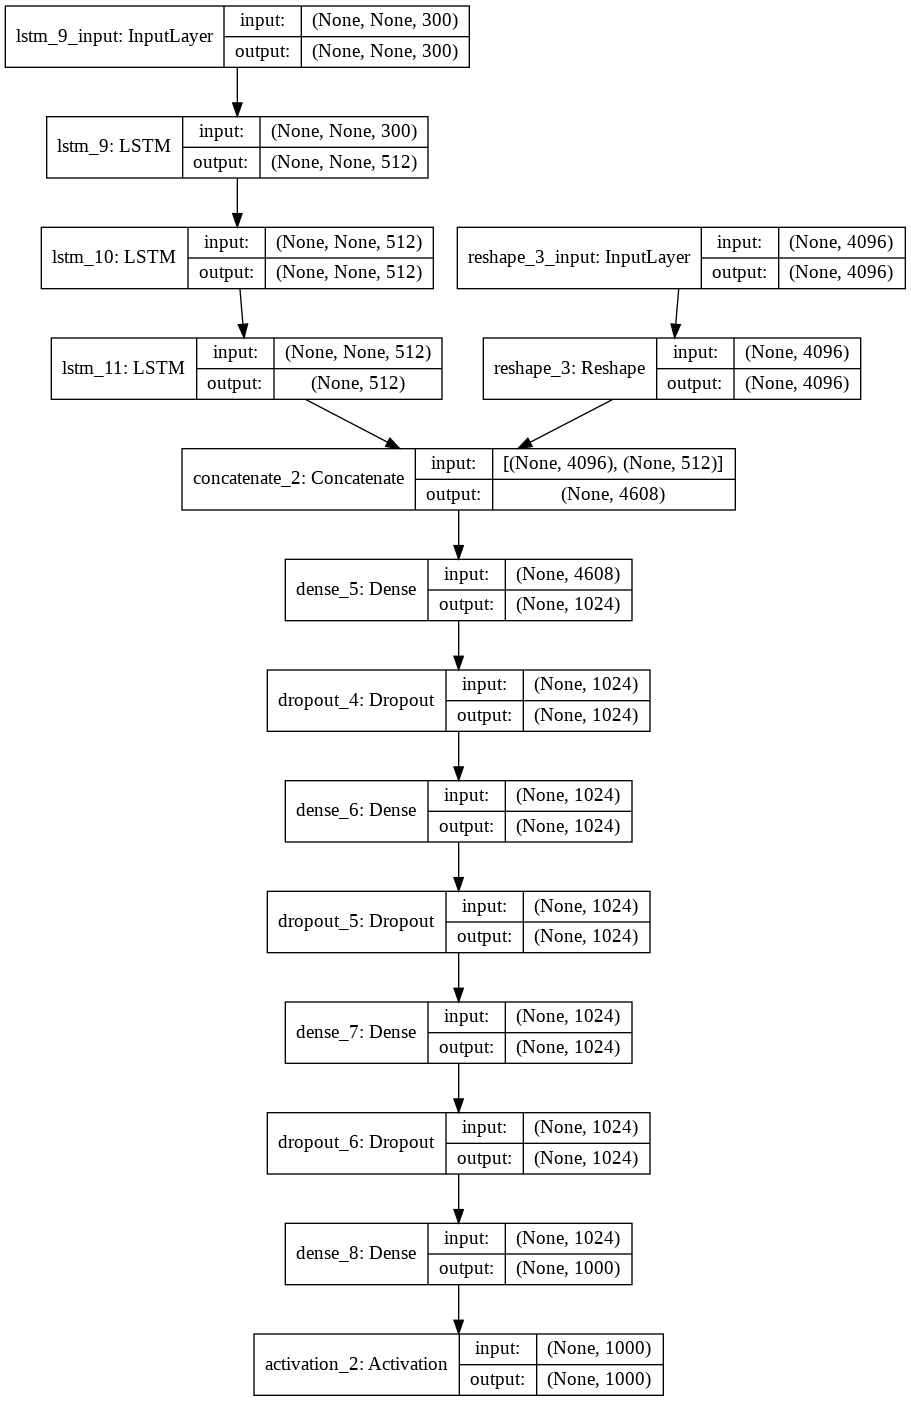

In [72]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def get_questions_tensor_timeseries(questions, nlp, timesteps):
    assert not isinstance(questions, list)
    nb_samples = len(questions)
    word_vec_dim = nlp(questions[0])[0].vector.shape[0]
    questions_tensor = np.zeros((nb_samples, timesteps, word_vec_dim))
    for i in range(len(questions)):
        tokens = nlp(questions[i])
        for j in range(len(tokens)):
            if j<timesteps:
                questions_tensor[i,j,:] = tokens[j].vector
    return questions_tensor

def get_images_matrix(img_coco_ids, img_map, VGGfeatures):
    assert not isinstance(img_coco_ids, list)
    nb_samples = len(img_coco_ids)
    nb_dimensions = VGGfeatures.shape[0]
    image_matrix = np.zeros((nb_samples, nb_dimensions))
    for j in range(len(img_coco_ids)):
        image_matrix[j,:] = VGGfeatures[:,img_map[img_coco_ids[j]]]

    return image_matrix

def get_answers_sum(answers, encoder):
    assert not isinstance(answers, list)
    y = encoder.transform(answers)
    nb_classes = encoder.classes_.shape[0]
    Y = np_utils.to_categorical(y, nb_classes)
    return Y

def grouped(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
   #print(args)
    #for a in(zip_longest(*args, fillvalue=fillvalue)):
        #print(a)
    return zip_longest(*args, fillvalue=fillvalue)

### Train-Test Split

In [0]:
train_questions = questions[:95000]
train_answers = answers[:95000]
train_image_id = image_id[:95000]

test_questions = questions[95000:]
test_answers = answers[95000:]
test_image_id = image_id[95000:]

In [33]:
len(set(train_image_id))

40036

In [0]:
for k in range(num_epochs):
    print("Epoch Number: ",k+1)
    progbar = generic_utils.Progbar(len(train_questions))
    for question_batch, ans_batch, im_batch in zip(grouped(train_questions, batch_size, fillvalue=train_questions[-1]), 
                                               grouped(train_answers, batch_size, fillvalue=train_answers[-1]),
                                               grouped(train_image_id, batch_size, fillvalue=train_image_id[-1])):
        timestep = len(nlp(question_batch[-1]))
        X_ques_batch = get_questions_tensor_timeseries(question_batch, nlp, timestep)
        X_img_batch = get_images_matrix(im_batch, id_map, features)
        Y_batch = get_answers_sum(ans_batch, le)
        #print(X_img_batch.shape)
        loss = model.train_on_batch(({'lstm_1_input' : X_ques_batch, 'reshape_1_input' : X_img_batch}), Y_batch)
        progbar.add(batch_size, values=[('train loss', loss)])
        

In [0]:
label_encoder = pickle.load(open('baselinefiles/label_encoder_lstm.pkl','rb'))

In [0]:
y_pred = []
batch_size = 512 

#print ("Word2Vec Loaded!") 

widgets = ['Evaluating ', Percentage(), ' ', Bar(marker='#',left='[',right=']'), ' ', ETA()]
pbar = ProgressBar(widgets=widgets)

In [0]:
from tensorflow import keras
demoModel = keras.models.load_model('attn-lstm.h5')

In [49]:
for qu_batch,an_batch,im_batch in pbar(zip(grouped(test_questions, batch_size, 
                                                   fillvalue=test_questions[0]), 
                                           grouped(test_answers, batch_size, 
                                                   fillvalue=test_answers[0]), 
                                           grouped(test_image_id, batch_size, 
                                                   fillvalue=test_image_id[0]))):
    timesteps = len(nlp(qu_batch[-1]))
    X_ques_batch = get_questions_tensor_timeseries(qu_batch, nlp, timesteps)
    X_i_batch = get_images_matrix(im_batch, id_map, features)
    #X_batch = [X_ques_batch, X_i_batch]
    y_predict = demoModel.predict(({'lstm_1_input' : X_ques_batch, 'reshape_1_input' : X_i_batch}))
    y_predict = np.argmax(y_predict,axis=1)
    y_pred.extend(label_encoder.inverse_transform(y_predict))

Evaluating N/A% [#                                             ] Time:  0:07:24

In [0]:
correct_val = 0.0
total = 0


for pred, truth, ques, img in zip(y_pred, test_answers, test_questions, test_image_id):
    t_count = 0
    for _truth in truth.split(';'):
        if pred == truth:
            t_count += 1 
    if t_count >=1:
        correct_val +=1
    else:
        correct_val += float(t_count)/3

    total +=1

In [51]:

print ("Accuracy: ", round((correct_val/total)*100,2))

Accuracy:  20.81


In [0]:
# model.save("model.h5")

In [0]:
# import os
# os.chdir('/content/drive/My Drive/DL_Group/Project/DATA/Images/V2/val2014')
# !ls -1 | wc -l

ls: cannot open directory '.': Input/output error
0
